In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
sys.path.append(os.path.abspath(".."))

slurm0-gpu1nodeset-0
/home/akarsh_sakana_ai/nca-alife/src/science_notebooks
/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [4]:
# group.add_argument("--seed", type=int, default=0)
# group.add_argument("--save_dir", type=str, default=None)

# group = parser.add_argument_group("model")
# group.add_argument("--sim", type=str, default='boids')

# group = parser.add_argument_group("data")
# group.add_argument("--n_rollout_imgs", type=int, default=1)
# group.add_argument("--prompts", type=str, default="an artificial cell,a bacterium")
# group.add_argument("--clip_model", type=str, default="clip-vit-base-patch32") # clip-vit-base-patch32 or clip-vit-large-patch14
# group.add_argument("--coef_prompt", type=float, default=1.)
# group.add_argument("--coef_softmax", type=float, default=0.)
# group.add_argument("--coef_novelty", type=float, default=0.)

# group = parser.add_argument_group("optimization")
# group.add_argument("--bs", type=int, default=1)
# group.add_argument("--pop_size", type=int, default=16)
# group.add_argument("--n_iters", type=int, default=10000)
# group.add_argument("--sigma", type=float, default=1.)

In [5]:
cfg_default = dict(
    seed=0, save_dir=None,
    sim='boids',

    n_rollout_imgs=1,
    prompts="a cell",

    coef_prompt=1., coef_softmax=0.5, coef_novelty=0.,
    bs=1, pop_size=16,
    n_iters=10000,
    sigma=0.1,
)

seed_sweep = np.arange(4)

cfgs = []

prompt_sweep = [
    "a biological cell",
    "a network of neurons",
    "a virus and fungal colony",
    "a self-replicating pattern",
    "a caterpillar",
    "a pepperoni pizza",
]

for p1 in prompt_sweep:
    for p2 in prompt_sweep:
        prompt = f"{p1},{p2}"
        cfg = cfg_default.copy()
        cfg.update(sim='lenia_1.0', seed=len(cfgs), prompts=prompt, sigma=0.1)
        cfg.update(save_dir=f"/home/akarsh_sakana_ai/nca-alife-data/main_opt_temporal_lenia_boids/{len(cfgs)}")
        cfgs.append(cfg)

prompt_sweep = [
    "a biological cell",
    "collective intelligence",
    "a fibonacci spiral in nature",
    "a starfish",
    "a snake",
    "a tree with roots",
]
for p1 in prompt_sweep:
    for p2 in prompt_sweep:
        prompt = f"{p1},{p2}"
        cfg = cfg_default.copy()
        cfg.update(sim='boids', seed=len(cfgs), prompts=prompt, sigma=0.1)
        cfg.update(save_dir=f"/home/akarsh_sakana_ai/nca-alife-data/main_opt_temporal_lenia_boids/{len(cfgs)}")
        cfgs.append(cfg)


print(len(cfgs))

72


In [6]:
commands = experiment_utils.create_commands(cfgs, prefix='python main_opt.py', out_file='../science_scripts/main_opt_temporal_lenia_boids.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python main_opt.py --seed=0  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/main_opt_temporal_lenia_boids/0"  --sim="lenia_1.0" --n_rollout_imgs=1 --prompts="a biological cell,a biological cell"                       --coef_prompt=1.0 --coef_softmax=0.5 --coef_novelty=0.0 --bs=1 --pop_size=16 --n_iters=10000 --sigma=0.1
python main_opt.py --seed=1  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/main_opt_temporal_lenia_boids/1"  --sim="lenia_1.0" --n_rollout_imgs=1 --prompts="a biological cell,a network of neurons"                    --coef_prompt=1.0 --coef_softmax=0.5 --coef_novelty=0.0 --bs=1 --pop_size=16 --n_iters=10000 --sigma=0.1
python main_opt.py --seed=2  --save_dir="/home/akarsh_sakana_ai/nca-alife-data/main_opt_temporal_lenia_boids/2"  --sim="lenia_1.0" --n_rollout_imgs=1 --prompts="a biological cell,a virus and fungal colony"               --coef_prompt=1.0 --coef_softmax=0.5 --coef_novelty=0.0 --bs=1 --pop_size=16 --n_iters=10000 --sigma=0.1 
...
72 commands


# Visualize Results

In [7]:
import jax
import jax.numpy as jnp
import copy

In [8]:
df = []

for cfg in tqdm(cfgs):
    try:
        save_dir = cfg['save_dir']
        dfi = copy.copy(cfg)
        params, loss = util.load_pkl(save_dir, "best")
        dfi['loss'] = loss.item()
        dfi['params'] = params
        df.append(dfi)
    except Exception as e:
        print(e)
        break
df = pd.DataFrame(df)

  0%|          | 0/72 [00:00<?, ?it/s]

In [9]:
from create_sim import create_sim, FlattenSimulationParameters, rollout_and_embed_simulation, rollout_simulation

2024-11-09 16:33:13.906345: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


ParameterReshaper: 3117 parameters detected for optimization.


0it [00:00, ?it/s]

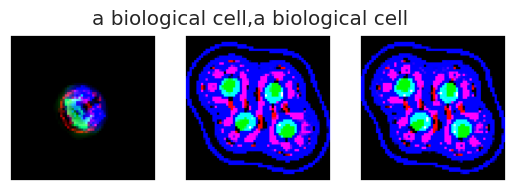

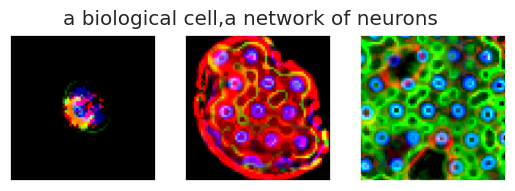

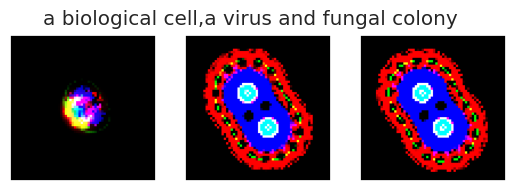

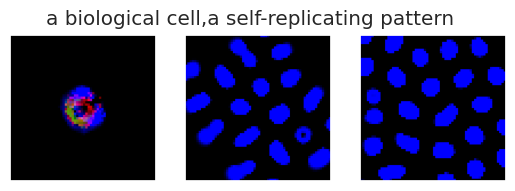

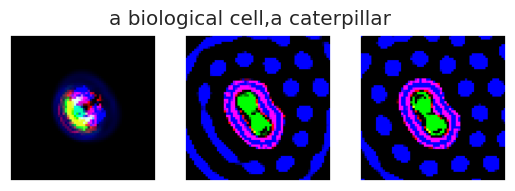

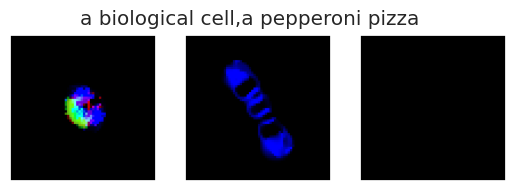

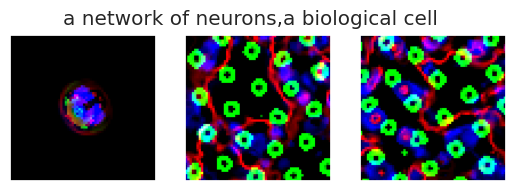

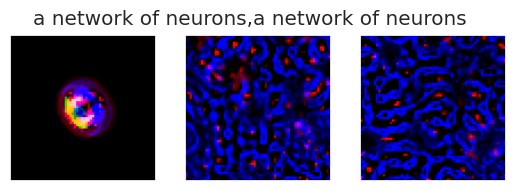

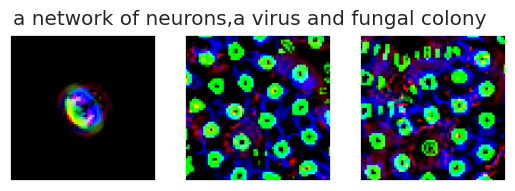

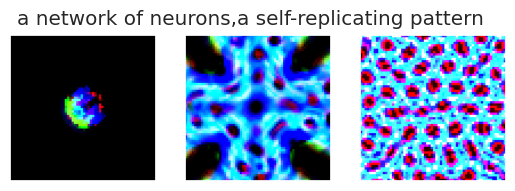

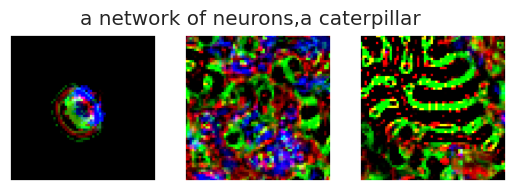

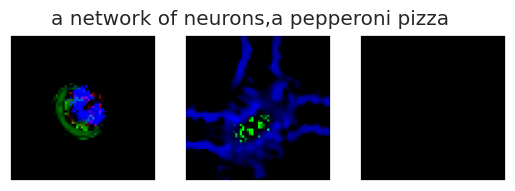

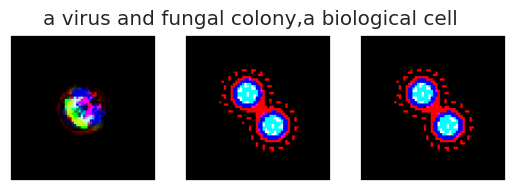

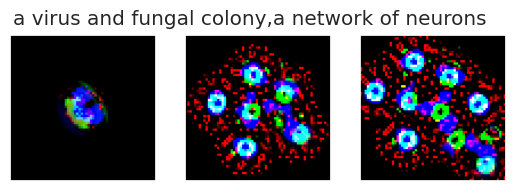

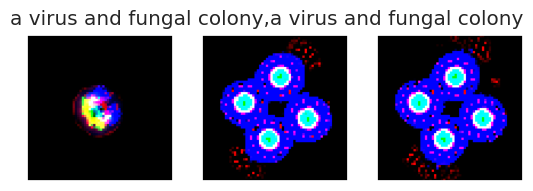

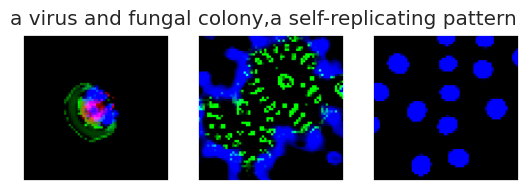

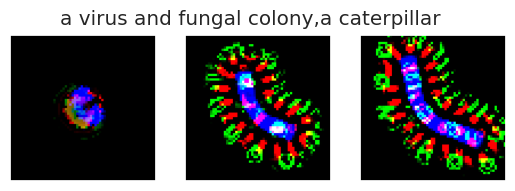

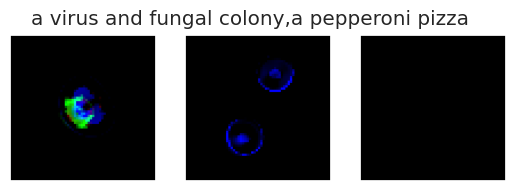

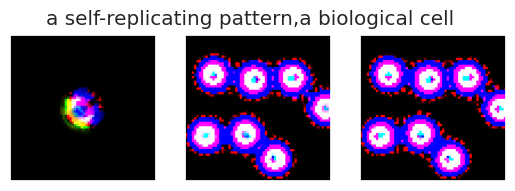

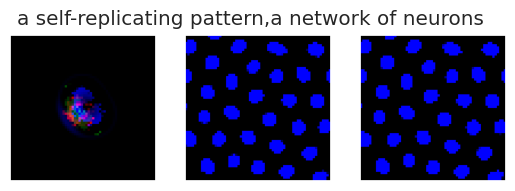

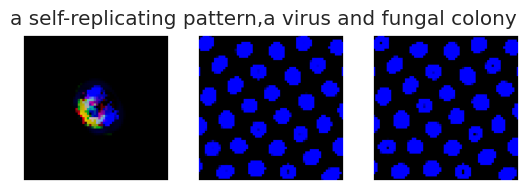

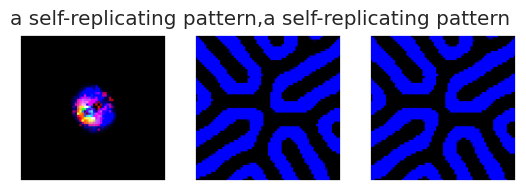

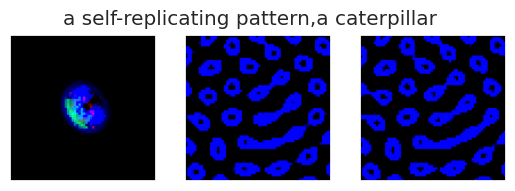

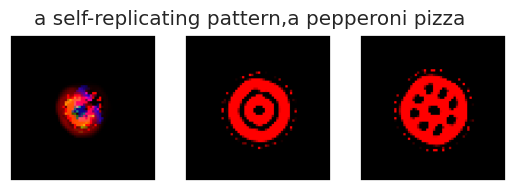

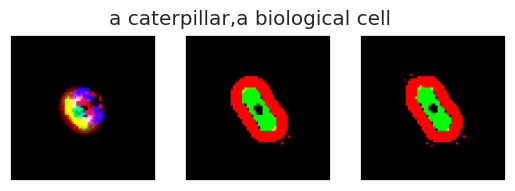

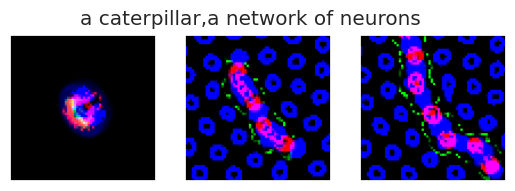

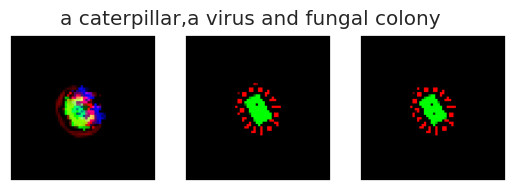

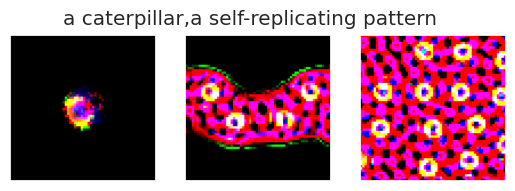

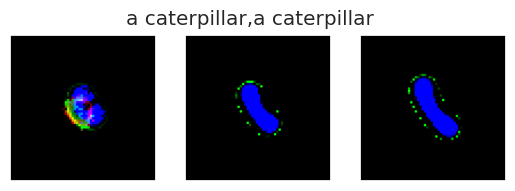

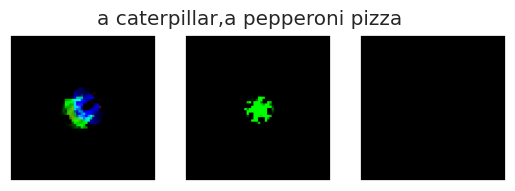

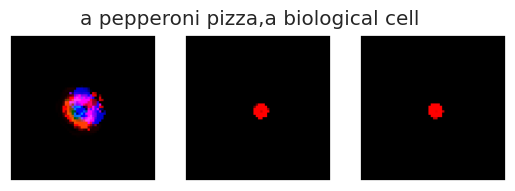

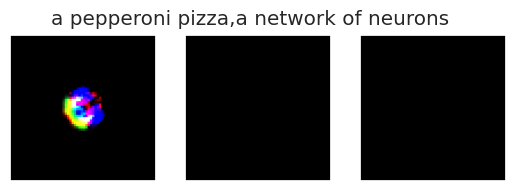

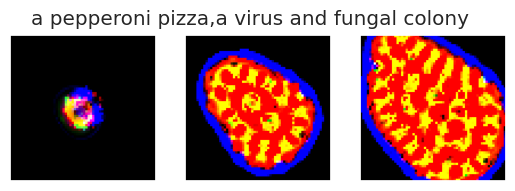

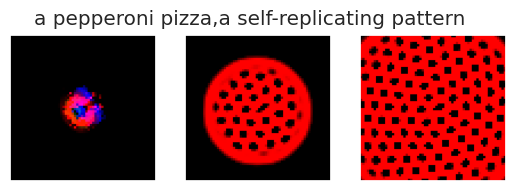

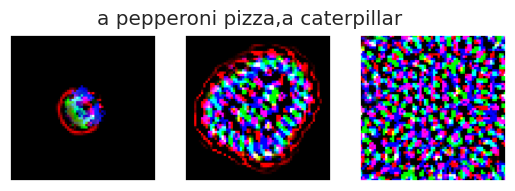

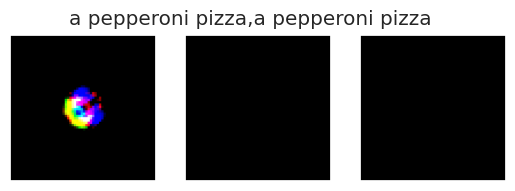

In [10]:
sim = create_sim('lenia_1.0')
sim = FlattenSimulationParameters(sim)
rollout_fn = partial(rollout_simulation, sim=sim, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs='video', img_size=256)
rollout_fn = jax.jit(rollout_fn)

rng = jax.random.PRNGKey(0)

for _, dfi in tqdm(df[:36].iterrows()):
    rollout_data = rollout_fn(rng, dfi['params'])
    plt.subplot(131); plt.imshow(rollout_data['rgb'][0]); plt.xticks([]); plt.yticks([])
    plt.subplot(132); plt.imshow(rollout_data['rgb'][128]); plt.xticks([]); plt.yticks([])
    plt.subplot(133); plt.imshow(rollout_data['rgb'][255]); plt.xticks([]); plt.yticks([])
    plt.suptitle(dfi['prompts'], y=0.7)
    plt.show()


ParameterReshaper: 193 parameters detected for optimization.


0it [00:00, ?it/s]

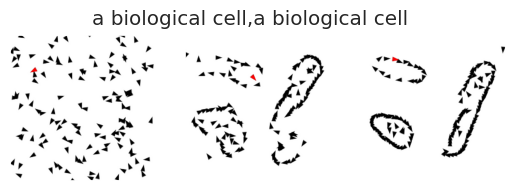

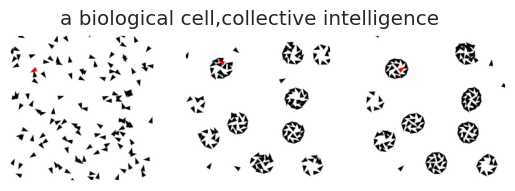

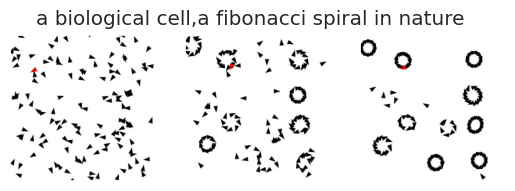

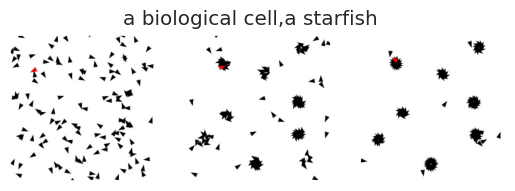

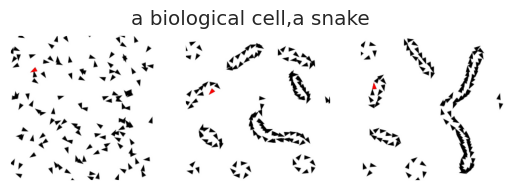

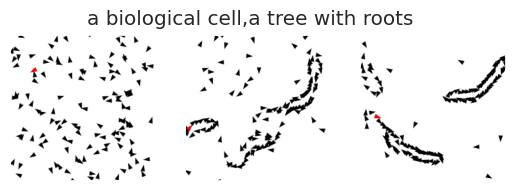

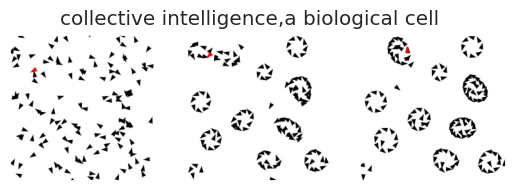

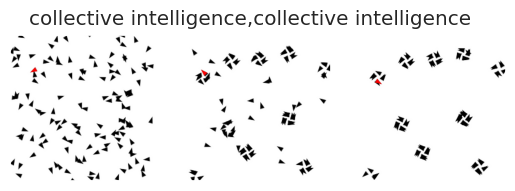

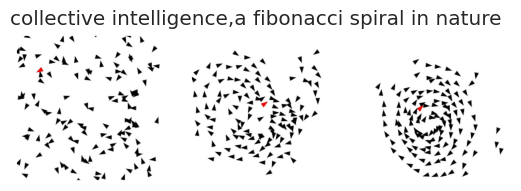

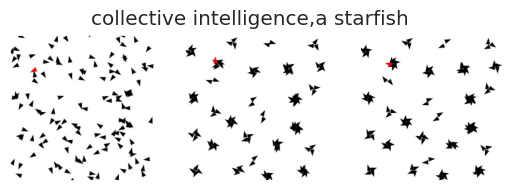

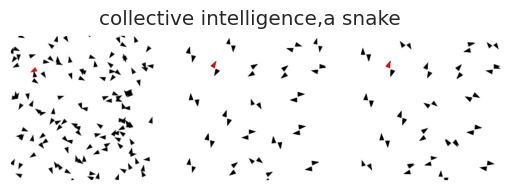

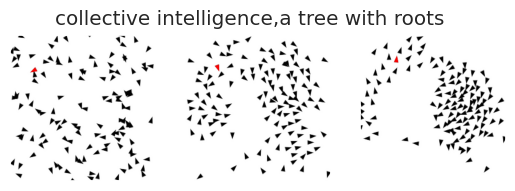

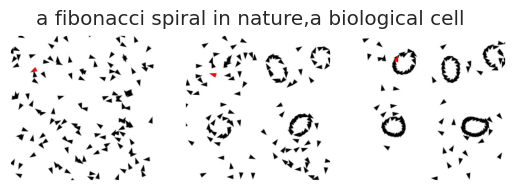

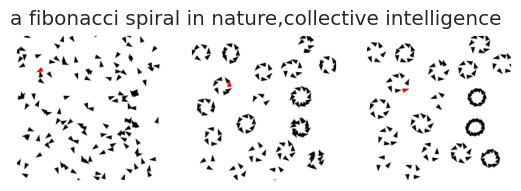

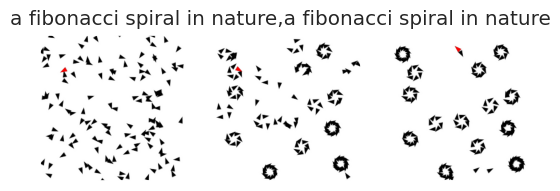

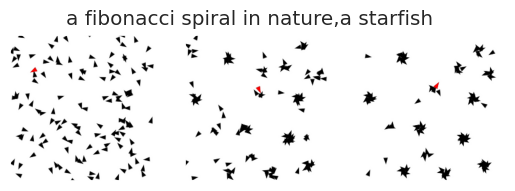

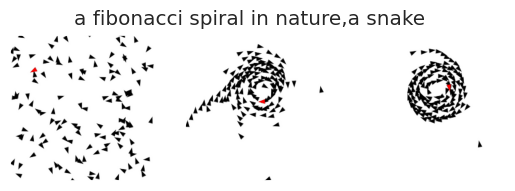

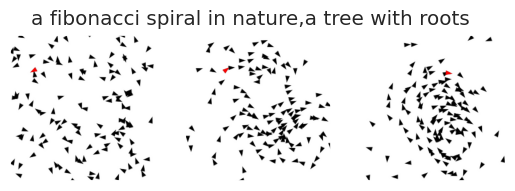

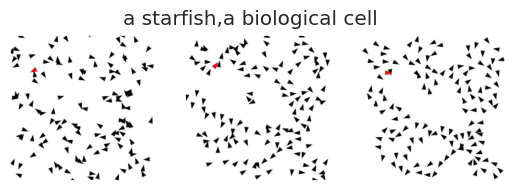

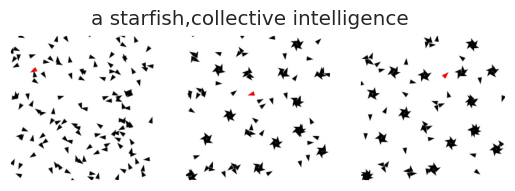

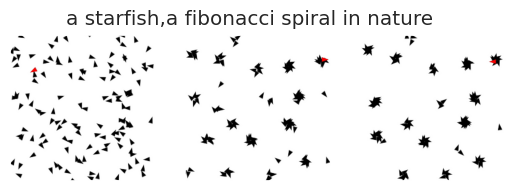

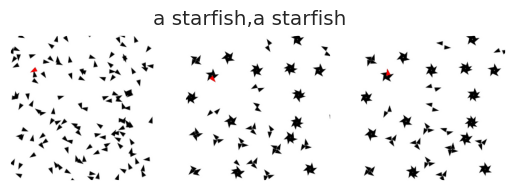

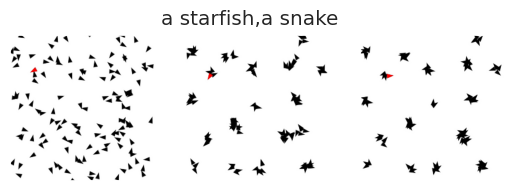

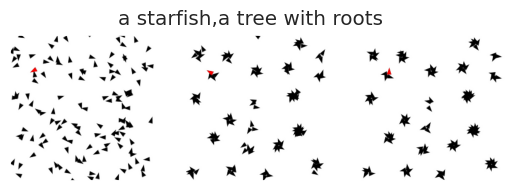

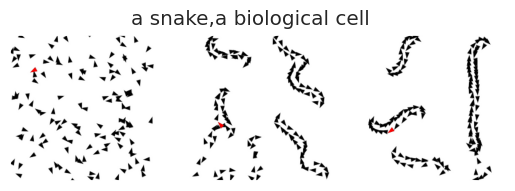

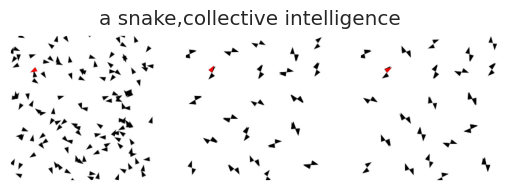

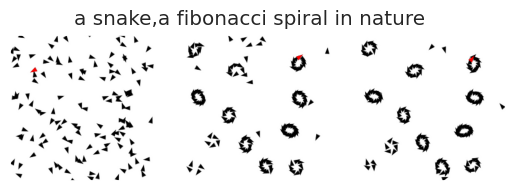

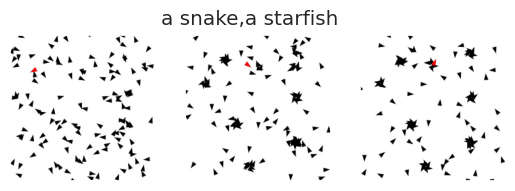

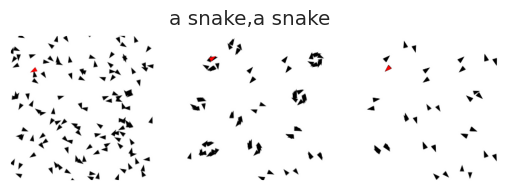

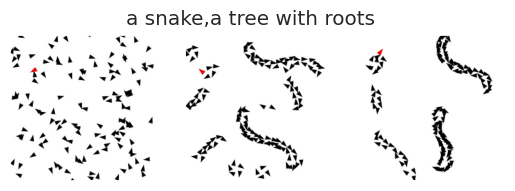

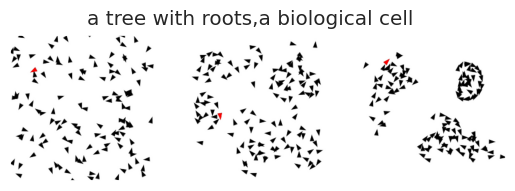

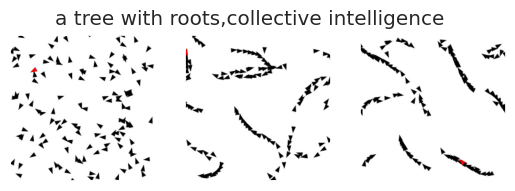

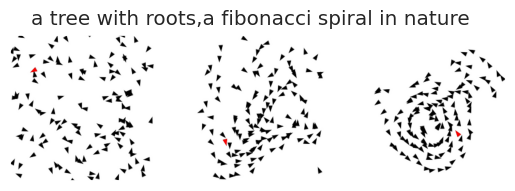

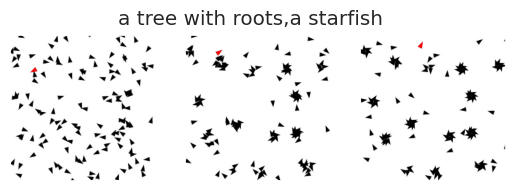

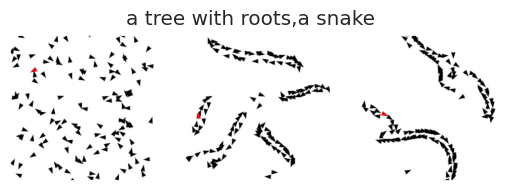

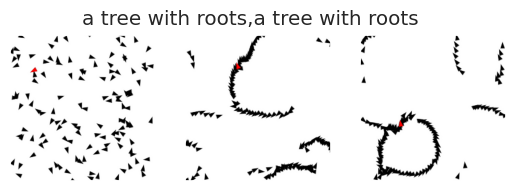

In [11]:
sim = create_sim('boids')
sim = FlattenSimulationParameters(sim)
rollout_fn = partial(rollout_simulation, sim=sim, rollout_steps=sim.sim.rollout_steps, n_rollout_imgs='video', img_size=256)
rollout_fn = jax.jit(rollout_fn)

rng = jax.random.PRNGKey(0)

for _, dfi in tqdm(df[36:].iterrows()):
    rollout_data = rollout_fn(rng, dfi['params'])
    plt.subplot(131); plt.imshow(rollout_data['rgb'][0]); plt.xticks([]); plt.yticks([])
    plt.subplot(132); plt.imshow(rollout_data['rgb'][128]); plt.xticks([]); plt.yticks([])
    plt.subplot(133); plt.imshow(rollout_data['rgb'][255]); plt.xticks([]); plt.yticks([])
    plt.suptitle(dfi['prompts'], y=0.7)
    plt.show()
